In [ ]:
# Connect with your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Set a Panda Dataframe with the appropriate labels
df = pd.read_csv("/content/2ROUND_DYNASENT_iemocap_semantic_analysis.csv")
df = df.rename(columns={"titre": "File", "to_translate": "Text", "emotion": "Acoustic_Annotation", "Semantic Analysis": "Semantic_Analysis"})


# Filter the DataFrame
filtered_df = df[(df['Acoustic_Annotation'].isin(['ang'])) & (df['Semantic_Analysis'] == 'positive')]
filtered_df2 = df[(df['Acoustic_Annotation'].isin(['hap'])) & (df['Semantic_Analysis'] == 'negative')]

# Concatenate the two filtered DataFrames
combined_df = pd.concat([filtered_df, filtered_df2], ignore_index=True)

combined_df

,File,Text,Acoustic_Annotation,Semantic_Analysis
0,Ses03M_script03_2_F002,Not at all. It was very pretty. I still hav...,ang,positive
1,Ses03M_script03_2_M041,Very amusing indeed.,ang,positive
2,Ses05F_script03_2_M041,Very music- amusing indeed.,ang,positive
3,Ses01M_script01_1_M035,"Yes, yes I like it for one hour a day. I don...",ang,positive
4,Ses05M_script03_2_M039,Very amusing indeed.,ang,positive
...,...,...,...,...
74,Ses01F_script03_1_M026,"Oh See, I don't care what you do, see. You c...",hap,negative
75,Ses01F_script03_1_F022,"Aw. Thank you, darling. The same applies to...",hap,negative
76,Ses01F_script03_1_F029,"The manager came in, he found us rolling abou...",hap,negative
77,Ses01M_script01_3_M000,"Yeah, that kind of went out of style didn't it?",hap,negative


In [ ]:
 #Copie your Kaggle API key
!cp /content/drive/MyDrive/Kaggle/kaggle.json /content/

# Download IEMOCAP
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download mouadriali/iemocap-transcriptions-english-french

!unzip '/content/iemocap-transcriptions-english-french.zip'

Streaming output truncated to the last 5000 lines.
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M016_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M017_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M018_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M019_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M020_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M021_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M022_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M023_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M024_mfcc.png  
  inflating: mfccs_figures-20220508T233533Z-001/mfccs_figures/Ses03M_impro05a_M025_mfcc.png  
  inflati

In [ ]:
!pip install praat-parselmouth
!pip install config
!pip install pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 70.5 MB/s eta 0:00:00


In [ ]:
#Measure pitch of all wav files in directory
import glob
import math
import numpy as np
import pandas as pd
import parselmouth
from parselmouth.praat import call

In [ ]:

def measurePitch(sound, f0min, f0max, unit):
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max)
    meanF0 = call(pitch, "Get mean", 0, 0, unit)
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit)
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    return meanF0, stdevF0, hnr

def speech_rate(filename):
    silencedb = -25
    mindip = 2
    minpause = 0.3
    sound = parselmouth.Sound(filename)
    originaldur = sound.get_total_duration()
    intensity = sound.to_intensity(50)
    start = call(intensity, "Get time from frame number", 1)
    nframes = call(intensity, "Get number of frames")
    end = call(intensity, "Get time from frame number", nframes)
    min_intensity = call(intensity, "Get minimum", 0, 0, "Parabolic")
    max_intensity = call(intensity, "Get maximum", 0, 0, "Parabolic")

    # get .99 quantile to get maximum (without influence of non-speech sound bursts)
    max_99_intensity = call(intensity, "Get quantile", 0, 0, 0.99)

    # estimate Intensity threshold
    threshold = max_99_intensity + silencedb
    threshold2 = max_intensity - max_99_intensity
    threshold3 = silencedb - threshold2
    if threshold < min_intensity:
        threshold = min_intensity

    # get pauses (silences) and speakingtime
    textgrid = call(intensity, "To TextGrid (silences)", threshold3, minpause, 0.1, "silent", "sounding")
    silencetier = call(textgrid, "Extract tier", 1)
    silencetable = call(silencetier, "Down to TableOfReal", "sounding")
    npauses = call(silencetable, "Get number of rows")
    speakingtot = 0
    for ipause in range(npauses):
        pause = ipause + 1
        beginsound = call(silencetable, "Get value", pause, 1)
        endsound = call(silencetable, "Get value", pause, 2)
        speakingdur = endsound - beginsound
        speakingtot += speakingdur

    intensity_matrix = call(intensity, "Down to Matrix")
    sound_from_intensity_matrix = call(intensity_matrix, "To Sound (slice)", 1)
    intensity_duration = call(sound_from_intensity_matrix, "Get total duration")
    point_process = call(sound_from_intensity_matrix, "To PointProcess (extrema)", "Left", "yes", "no", "Sinc70")
    numpeaks = call(point_process, "Get number of points")
    t = [call(point_process, "Get time from index", i + 1) for i in range(numpeaks)]

    timepeaks = []
    peakcount = 0
    intensities = []
    for i in range(numpeaks):
        value = call(sound_from_intensity_matrix, "Get value at time", t[i], "Cubic")
        if value > threshold:
            peakcount += 1
            intensities.append(value)
            timepeaks.append(t[i])

    validpeakcount = 0
    currenttime = timepeaks[0]
    currentint = intensities[0]
    validtime = []

    for p in range(peakcount - 1):
        following = p + 1
        followingtime = timepeaks[p + 1]
        dip = call(intensity, "Get minimum", currenttime, timepeaks[p + 1], "None")
        diffint = abs(currentint - dip)
        if diffint > mindip:
            validpeakcount += 1
            validtime.append(timepeaks[p])
        currenttime = timepeaks[following]
        currentint = call(intensity, "Get value at time", timepeaks[following], "Cubic")

    pitch = sound.to_pitch_ac(0.02, 30, 4, False, 0.03, 0.25, 0.01, 0.35, 0.25, 450)
    voicedcount = 0
    voicedpeak = []

    for time in range(validpeakcount):
        querytime = validtime[time]
        whichinterval = call(textgrid, "Get interval at time", 1, querytime)
        whichlabel = call(textgrid, "Get label of interval", 1, whichinterval)
        value = pitch.get_value_at_time(querytime)
        if not math.isnan(value):
            if whichlabel == "sounding":
                voicedcount += 1
                voicedpeak.append(validtime[time])

    timecorrection = originaldur / intensity_duration

    speakingrate = voicedcount / originaldur
    articulationrate = voicedcount / speakingtot
    npause = npauses - 1
    asd = speakingtot / voicedcount
    speechrate_dictionary = {'soundname':filename,
                             'nsyll':voicedcount,
                             'npause': npause,
                             'dur(s)':originaldur,
                             'phonationtime(s)':intensity_duration,
                             'speechrate(nsyll / dur)': speakingrate,
                             "articulation rate(nsyll / phonationtime)":articulationrate,
                             "ASD(speakingtime / nsyll)":asd}
    return speechrate_dictionary




In [ ]:

# Set a Panda Dataframe with the appropriate labels
df = combined_df

# Create lists to put the results
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
intensity_list = []
Acoustic_Annotation_list = []
Semantic_Prediction_list = []
speech_rate_list = []  # List to hold speech rates
articulation_rate_list = []  # List to hold articulation rates
avg_syllable_duration_list = []  # List to hold average syllable duration

# Go through all the rows in the DataFrame
for _, row in df.iterrows():
    audio_name = str(row["File"])
    path = "/content/Iemocap_audio/iemocap_audio/IEMOCAP_wav/"
    audio_file_path = path + audio_name + ".wav"

    # Measure pitch using your function (measurePitch)
    sound = parselmouth.Sound(audio_file_path)
    meanF0, stdevF0, hnr = measurePitch(sound, 75, 500, "Hertz")

    # Get intensity average
    intensity = sound.to_intensity()
    intensity_avg = intensity.get_average()

    # Calculate speech rate
    speech_rate_dict = speech_rate(audio_file_path)
    speech_rate_val = speech_rate_dict['speechrate(nsyll / dur)']

    # Extract articulation rate and average syllable duration from speech rate dictionary
    articulation_rate_val = speech_rate_dict["articulation rate(nsyll / phonationtime)"]
    avg_syllable_duration_val = speech_rate_dict["ASD(speakingtime / nsyll)"]

    # Append values to lists
    file_list.append(audio_file_path)
    mean_F0_list.append(meanF0)
    sd_F0_list.append(stdevF0)
    hnr_list.append(hnr)
    intensity_list.append(intensity_avg)
    Semantic_Prediction_list.append(row['Semantic_Analysis'])
    Acoustic_Annotation_list.append(row['Acoustic_Annotation'])
    speech_rate_list.append(speech_rate_val)
    articulation_rate_list.append(articulation_rate_val)
    avg_syllable_duration_list.append(avg_syllable_duration_val)

# Create a DataFrame with all the collected information
df_features = pd.DataFrame({
    'voiceID': file_list,
    'meanF0Hz': mean_F0_list,
    'stdevF0Hz': sd_F0_list,
    'HNR': hnr_list,
    'IntensityAvg': intensity_list,
    'SpeechRate': speech_rate_list,
    'ArticulationRate': articulation_rate_list,
    'AvgSyllableDuration': avg_syllable_duration_list,
    'Semantic_Analysis': Semantic_Prediction_list,
    'Acoustic_Annotation': Acoustic_Annotation_list
})

df_features.head(100)

,voiceID,meanF0Hz,stdevF0Hz,HNR,IntensityAvg,SpeechRate,ArticulationRate,AvgSyllableDuration,Semantic_Analysis,Acoustic_Annotation
0,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,283.947275,72.350889,12.226518,56.601938,3.413073,4.915730,0.203429,positive,ang
1,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,90.668142,23.957232,7.983038,49.558740,1.359042,1.359042,0.735812,positive,ang
2,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,164.869988,44.171457,11.670687,67.496111,2.952098,4.125905,0.242371,positive,ang
3,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,206.323458,35.033386,9.995606,75.055523,3.485274,4.390424,0.227768,positive,ang
4,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,206.033320,58.799703,9.600989,72.715691,3.149606,4.530011,0.220750,positive,ang
...,...,...,...,...,...,...,...,...,...,...
74,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,154.804728,41.700746,13.222525,67.149133,2.886361,4.159817,0.240395,negative,hap
75,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,186.055889,39.755836,9.213255,62.766618,3.820987,5.510076,0.181486,negative,hap
76,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,220.077899,64.478227,8.278268,73.151072,3.276020,4.400939,0.227224,negative,hap
77,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,119.804725,16.677850,10.259335,61.704031,2.141614,2.936242,0.340571,negative,hap


In [ ]:
# Define a function to create the tag
def create_tag(row):
    if row['Semantic_Analysis'] == 'negative' and row['Acoustic_Annotation'] == 'hap':
        return 'Kind Irony'
    elif row['Semantic_Analysis'] == 'positive' and row['Acoustic_Annotation'] == 'ang':
        return 'Sarcasm'
    else:
        return 'Other'

# Apply the function to create the tag column
df_features['Tag'] = df_features.apply(create_tag, axis=1)

# Print the updated DataFrame
df_features.head(100)

,voiceID,meanF0Hz,stdevF0Hz,HNR,IntensityAvg,SpeechRate,ArticulationRate,AvgSyllableDuration,Semantic_Analysis,Acoustic_Annotation,Tag
0,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,283.947275,72.350889,12.226518,56.601938,3.413073,4.915730,0.203429,positive,ang,Sarcasm
1,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,90.668142,23.957232,7.983038,49.558740,1.359042,1.359042,0.735812,positive,ang,Sarcasm
2,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,164.869988,44.171457,11.670687,67.496111,2.952098,4.125905,0.242371,positive,ang,Sarcasm
3,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,206.323458,35.033386,9.995606,75.055523,3.485274,4.390424,0.227768,positive,ang,Sarcasm
4,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,206.033320,58.799703,9.600989,72.715691,3.149606,4.530011,0.220750,positive,ang,Sarcasm
...,...,...,...,...,...,...,...,...,...,...,...
74,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,154.804728,41.700746,13.222525,67.149133,2.886361,4.159817,0.240395,negative,hap,Kind Irony
75,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,186.055889,39.755836,9.213255,62.766618,3.820987,5.510076,0.181486,negative,hap,Kind Irony
76,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,220.077899,64.478227,8.278268,73.151072,3.276020,4.400939,0.227224,negative,hap,Kind Irony
77,/content/Iemocap_audio/iemocap_audio/IEMOCAP_w...,119.804725,16.677850,10.259335,61.704031,2.141614,2.936242,0.340571,negative,hap,Kind Irony


In [ ]:
print (df_features)
df_features.to_csv("2Rnd_3BERT_features_KindIrony_vs_Sarcasm.csv", index=False)


                                              voiceID    meanF0Hz  stdevF0Hz  \
0   /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...  283.947275  72.350889   
1   /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...   90.668142  23.957232   
2   /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...  164.869988  44.171457   
3   /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...  206.323458  35.033386   
4   /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...  206.033320  58.799703   
..                                                ...         ...        ...   
74  /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...  154.804728  41.700746   
75  /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...  186.055889  39.755836   
76  /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...  220.077899  64.478227   
77  /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...  119.804725  16.677850   
78  /content/Iemocap_audio/iemocap_audio/IEMOCAP_w...  223.027746  69.314069   

          HNR  IntensityAvg  SpeechRate

In [ ]:
# Count the number of occurrences of each tag
tag_counts = df_features['Tag'].value_counts()

# Print the counts
print("Kind Irony:", tag_counts.get('Kind Irony', 0))
print("Sarcasm:", tag_counts.get('Sarcasm', 0))

Kind Irony: 51
Sarcasm: 28


In [ ]:
import pandas as pd

# Assuming 'df_features' is your DataFrame and 'Tag' is the column containing 'Sincere' and 'Kind Irony'
# Remove any rows with NaN values
df_features = df_features.dropna()

# Get the counts of each tag
tag_counts = df_features['Tag'].value_counts()

# Set min_size to the smaller of the two counts for balancing
min_size = min(tag_counts.get('Kind Irony', 0), tag_counts.get('Sarcasm', 0))

# Check if there are enough entries to sample min_size rows
if min_size > 0:
    # Randomly sample min_size entries from each tag
    df_Sarcasm = df_features[df_features['Tag'] == 'Sarcasm'].sample(n=min_size, random_state=42)
    df_kind_irony = df_features[df_features['Tag'] == 'Kind Irony'].sample(n=min_size, random_state=42)

    # Combine the two balanced samples into a new DataFrame
    df_balanced = pd.concat([df_Sarcasm, df_kind_irony])

    # Verify the counts to ensure equal size
    print(df_balanced['Tag'].value_counts())
else:
    print("Not enough data to balance both tags.")


Tag
Sarcasm       28
Kind Irony    28
Name: count, dtype: int64


In [ ]:
# Filter for female and male entries
female_entries = df_balanced[df_balanced['voiceID'].str.contains(r'F\d{3}')]
male_entries = df_balanced[df_balanced['voiceID'].str.contains(r'M\d{3}')]

# Calculate statistics grouped by 'Tag' for female entries
statistics_female_by_tag = female_entries.groupby('Tag')[['meanF0Hz', 'stdevF0Hz', 'HNR', 'IntensityAvg', 'SpeechRate', 'ArticulationRate', 'AvgSyllableDuration']].describe()
statistics_female_by_tag.to_csv("2Rnd_3BERT_statistics_female_by_tag_KindIrony_vs_Sarcasm.csv")

# Calculate statistics grouped by 'Tag' for male entries
statistics_male_by_tag = male_entries.groupby('Tag')[['meanF0Hz', 'stdevF0Hz', 'HNR', 'IntensityAvg', 'SpeechRate', 'ArticulationRate', 'AvgSyllableDuration']].describe()
statistics_male_by_tag.to_csv("2Rnd_3BERT_statistics_male_by_tag_KindIrony_vs_Sarcasm.csv")

# Print the statistics
print("Female Entries Statistics:")
print(statistics_female_by_tag)
print("\nMale Entries Statistics:")
print(statistics_male_by_tag)

Female Entries Statistics:
           meanF0Hz                                                 \
              count        mean        std         min         25%   
Tag                                                                  
Kind Irony     22.0  239.395495  44.551226  155.021988  212.252150   
Sarcasm         6.0  258.328004  47.980171  205.891161  215.196178   

                                               stdevF0Hz             ...  \
                   50%         75%         max     count       mean  ...   
Tag                                                                  ...   
Kind Irony  228.690999  271.873420  327.974709      22.0  65.048781  ...   
Sarcasm     260.787418  292.340429  319.644832       6.0  66.894655  ...   

           ArticulationRate           AvgSyllableDuration                      \
                        75%       max               count      mean       std   
Tag                                                                            

In [ ]:
from scipy import stats
import pandas as pd

# Create empty lists to store results for each gender
shapiro_pair_results_female = []
levene_pair_results_female = []
significance_pair_results_female = []
shapiro_pair_results_male = []
levene_pair_results_male = []
significance_pair_results_male = []

# Define features to test
features = ['meanF0Hz', 'stdevF0Hz', 'HNR', 'IntensityAvg', 'SpeechRate', 'ArticulationRate', 'AvgSyllableDuration']

# Separate entries by gender
female_entries = df_balanced[df_balanced['voiceID'].str.contains(r'F\d{3}')]
male_entries = df_balanced[df_balanced['voiceID'].str.contains(r'M\d{3}')]

# Function to perform tests and store results
def perform_tests(data_a, data_b, gender_label):
    shapiro_results = []
    levene_results = []
    significance_results = []

    for feature in features:
        # Shapiro-Wilk test for normality
        w_statistic_a, p_value_a = stats.shapiro(data_a[feature])
        is_normal_a = p_value_a > 0.05
        w_statistic_b, p_value_b = stats.shapiro(data_b[feature])
        is_normal_b = p_value_b > 0.05

        shapiro_results.append({
            'Gender': gender_label,
            'Feature': feature,
            'Mood A': 'Kind Irony',
            'W-statistic A': w_statistic_a,
            'P-value A': p_value_a,
            'Normal Distribution A': is_normal_a,
            'Mood B': 'Sarcasm',
            'W-statistic B': w_statistic_b,
            'P-value B': p_value_b,
            'Normal Distribution B': is_normal_b
        })

        # Levene's test for equal variance
        levene_stat, p_value = stats.levene(data_a[feature], data_b[feature])
        is_equal_variance = p_value > 0.05
        levene_results.append({
            'Gender': gender_label,
            'Feature': feature,
            'Levene-statistic': levene_stat,
            'P-value': p_value,
            'Equal Variance': is_equal_variance
        })

        # Perform appropriate test based on normality and equal variance
        if is_normal_a and is_normal_b:  # If data is normally distributed
            t_statistic, p_value = stats.ttest_ind(data_a[feature], data_b[feature], equal_var=is_equal_variance)
            test_name = 'Student t-test' if is_equal_variance else 'Welch t-Test'
        else:  # If data is not normally distributed
            t_statistic, p_value = stats.mannwhitneyu(data_a[feature], data_b[feature])
            test_name = 'Mann-Whitney U-test'

        is_significant = p_value < 0.05
        significance_results.append({
            'Gender': gender_label,
            'Feature': feature,
            'Test': test_name,
            'Statistic': t_statistic,
            'P-value': p_value,
            'Significant': is_significant
        })

    return shapiro_results, levene_results, significance_results

# Perform tests for female entries
female_kind_irony = female_entries[female_entries['Tag'] == 'Kind Irony']
female_sarcasm = female_entries[female_entries['Tag'] == 'Sarcasm']
results_female = perform_tests(female_kind_irony, female_sarcasm, 'Female')
shapiro_pair_results_female, levene_pair_results_female, significance_pair_results_female = results_female

# Perform tests for male entries
male_kind_irony = male_entries[male_entries['Tag'] == 'Kind Irony']
male_sarcasm = male_entries[male_entries['Tag'] == 'Sarcasm']
results_male = perform_tests(male_kind_irony, male_sarcasm, 'Male')
shapiro_pair_results_male, levene_pair_results_male, significance_pair_results_male = results_male

# Combine results into a single DataFrame
df_shapiro = pd.DataFrame(shapiro_pair_results_female + shapiro_pair_results_male)
df_levene = pd.DataFrame(levene_pair_results_female + levene_pair_results_male)
df_significance_Male_Female = pd.DataFrame(significance_pair_results_female + significance_pair_results_male)

# Merge DataFrames into one
df_combined = pd.concat([df_shapiro, df_levene[['Levene-statistic', 'P-value', 'Equal Variance']], df_significance_Male_Female[['Test', 'Statistic', 'P-value', 'Significant']]], axis=1)

# Save the combined results to a single CSV file
df_combined.to_csv("statistical_tests_results_combined__KindIrony_vs_Sarcasm.csv", index=False)

# Print or use DataFrame as required
print("Combined Statistical Tests Results:")
print(df_combined)




Combined Statistical Tests Results:
    Gender              Feature      Mood A  W-statistic A  P-value A  \
0   Female             meanF0Hz  Kind Irony       0.969410   0.697419   
1   Female            stdevF0Hz  Kind Irony       0.966026   0.619527   
2   Female                  HNR  Kind Irony       0.965051   0.597490   
3   Female         IntensityAvg  Kind Irony       0.975070   0.824297   
4   Female           SpeechRate  Kind Irony       0.950748   0.326788   
5   Female     ArticulationRate  Kind Irony       0.980396   0.922082   
6   Female  AvgSyllableDuration  Kind Irony       0.918997   0.072472   
7     Male             meanF0Hz  Kind Irony       0.881717   0.277034   
8     Male            stdevF0Hz  Kind Irony       0.817487   0.083931   
9     Male                  HNR  Kind Irony       0.968811   0.884356   
10    Male         IntensityAvg  Kind Irony       0.966411   0.867517   
11    Male           SpeechRate  Kind Irony       0.946393   0.711003   
12    Male     

In [ ]:
df_significance_Male_Female

,Gender,Feature,Test,Statistic,P-value,Significant
0,Female,meanF0Hz,Student t-test,-0.908828,0.371789,False
1,Female,stdevF0Hz,Student t-test,-0.186882,0.853203,False
2,Female,HNR,Student t-test,1.376337,0.180456,False
3,Female,IntensityAvg,Student t-test,-0.591106,0.559554,False
4,Female,SpeechRate,Student t-test,0.726083,0.474274,False
5,Female,ArticulationRate,Student t-test,-0.202961,0.840745,False
6,Female,AvgSyllableDuration,Mann-Whitney U-test,69.000000,0.891607,False
7,Male,meanF0Hz,Student t-test,-1.892358,0.069629,False
8,Male,stdevF0Hz,Mann-Whitney U-test,52.000000,0.459872,False
9,Male,HNR,Student t-test,-0.026657,0.978936,False


In [ ]:
import numpy as np
import pandas as pd

# Data for "Kind Irony" and "Sarcasm" features (mean and standard deviation)
data = {
    'Feature': [
        'Mean F0 (Hz)',
        'Stdev F0 (Hz)',
        'Average Intensity (dB)',
        'Speech Rate (syl/sec)',
        'Articulation Rate (syl/sec)',
        'Average Syllable Duration (sec)'
    ],
    'Mean_Kind_Irony': [194.13, 57.23, 57.79, 3.27, 3.89, 0.28],
    'Std_Kind_Irony': [54.53, 29.34, 8.14, 0.91, 0.95, 0.10],
    'Mean_Sarcasm': [177.28, 43.17, 50.98, 2.99, 3.63, 0.31],
    'Std_Sarcasm': [59.21, 28.07, 6.39, 0.92, 1.03, 0.13]
}

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Calculate Cohen's d
# Cohen's d = (Mean1 - Mean2) / Pooled Std Dev
# Pooled Std Dev = sqrt(((Std1^2 + Std2^2) / 2))
df['Pooled_Std'] = np.sqrt((df['Std_Kind_Irony']**2 + df['Std_Sarcasm']**2) / 2)
df['Cohens_d'] = (df['Mean_Kind_Irony'] - df['Mean_Sarcasm']) / df['Pooled_Std']

# Display the results
print("Effect Size (Cohen's d) for each feature:")
print(df[['Feature', 'Cohens_d']])


Effect Size (Cohen's d) for each feature:
                           Feature  Cohens_d
0                     Mean F0 (Hz)  0.296039
1                    Stdev F0 (Hz)  0.489690
2           Average Intensity (dB)  0.930645
3            Speech Rate (syl/sec)  0.306006
4      Articulation Rate (syl/sec)  0.262412
5  Average Syllable Duration (sec) -0.258678


In [ ]:
import pandas as pd
import numpy as np

# Assuming df_features is already loaded

# Function to calculate Cohen's d
def cohen_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    sd1, sd2 = np.std(group1, ddof=1), np.std(group2, ddof=1)

    # Pooled standard deviation
    sd_pooled = np.sqrt(((n1 - 1) * sd1**2 + (n2 - 1) * sd2**2) / (n1 + n2 - 2))

    # Cohen's d
    d = (mean1 - mean2) / sd_pooled
    return d

# Prepare the DataFrame for results
effect_sizes = []

# List of features to evaluate
features = ['meanF0Hz', 'stdevF0Hz', 'HNR', 'IntensityAvg', 'SpeechRate', 'ArticulationRate', 'AvgSyllableDuration']

# Calculate Cohen's d for each feature
for feature in features:
    group1 = df_features[df_features['Tag'] == 'Kind Irony'][feature]
    group2 = df_features[df_features['Tag'] == 'Sarcasm'][feature]
    d_value = cohen_d(group1, group2)
    effect_sizes.append({'Feature': feature, "Cohen's d": d_value})

# Convert to DataFrame
effect_sizes_df = pd.DataFrame(effect_sizes)

# Display the results
print(effect_sizes_df)


               Feature  Cohen's d
0             meanF0Hz   0.279336
1            stdevF0Hz   0.484650
2                  HNR   0.329330
3         IntensityAvg   0.943174
4           SpeechRate   0.294671
5     ArticulationRate   0.239683
6  AvgSyllableDuration  -0.178316


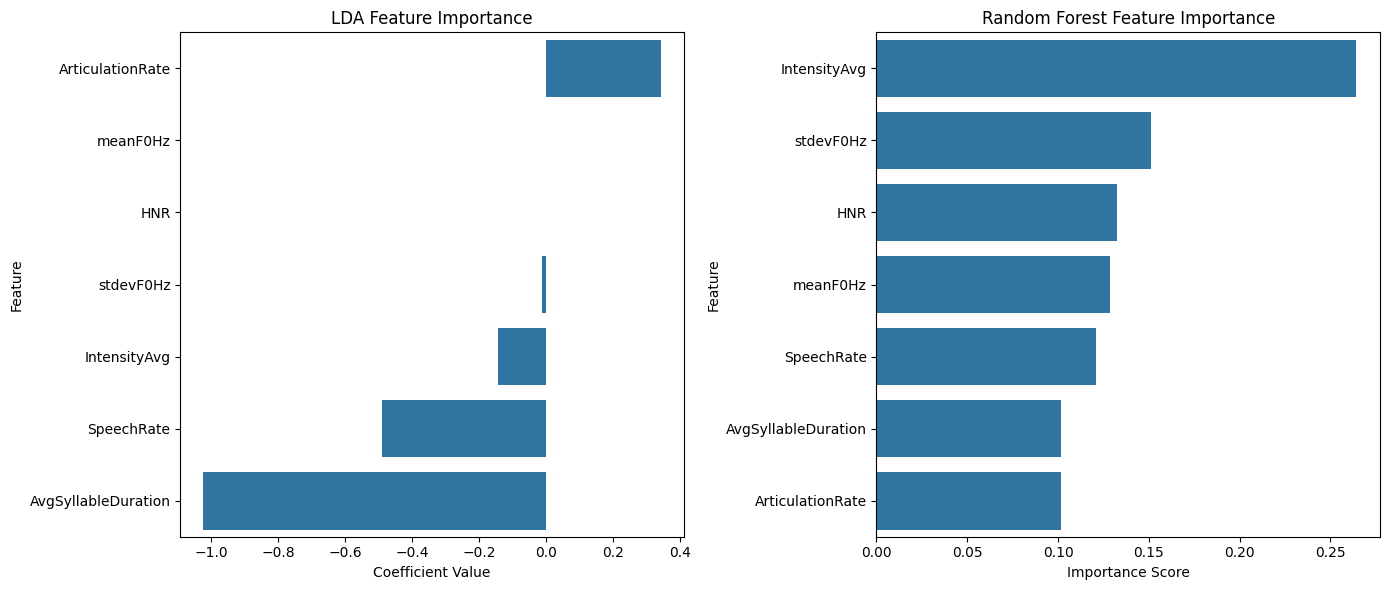

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Corrected import
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Assuming df_features is already loaded

# Prepare the data
X = df_features.drop(['voiceID', 'Semantic Prediction', 'Acoustic Annotation', 'Tag'], axis=1)
y = df_features['Tag']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_coefficients = lda.coef_[0]

# Feature importance from LDA
lda_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'LDA Coefficient': lda_coefficients
}).sort_values(by='LDA Coefficient', ascending=False)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature importance from Random Forest
rf_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest Importance': rf.feature_importances_
}).sort_values(by='Random Forest Importance', ascending=False)

# Visualization
plt.figure(figsize=(14, 6))

# LDA Feature Importance
plt.subplot(1, 2, 1)
sns.barplot(x='LDA Coefficient', y='Feature', data=lda_feature_importance)
plt.title('LDA Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

# Random Forest Feature Importance
plt.subplot(1, 2, 2)
sns.barplot(x='Random Forest Importance', y='Feature', data=rf_feature_importance)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()


In [ ]:

print(lda_feature_importance)
print(rf_feature_importance)

               Feature  LDA Coefficient
5     ArticulationRate         0.342605
0             meanF0Hz        -0.000557
2                  HNR        -0.000987
1            stdevF0Hz        -0.012777
3         IntensityAvg        -0.144393
4           SpeechRate        -0.490861
6  AvgSyllableDuration        -1.024434
               Feature  Random Forest Importance
3         IntensityAvg                  0.264059
1            stdevF0Hz                  0.151258
2                  HNR                  0.132315
0             meanF0Hz                  0.128522
4           SpeechRate                  0.120841
6  AvgSyllableDuration                  0.101551
5     ArticulationRate                  0.101455


               Feature       AUC
0             meanF0Hz  0.483103
1            stdevF0Hz  0.512451
2                  HNR  0.537451
3         IntensityAvg  0.651383
4           SpeechRate  0.471789
5     ArticulationRate  0.438785
6  AvgSyllableDuration  0.439872


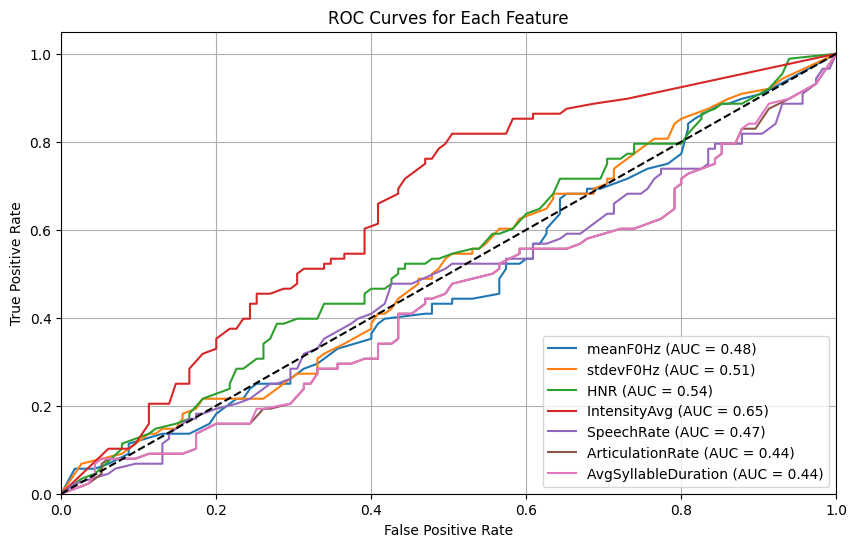

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Function to calculate AUC-ROC for each feature
def calculate_auc_roc(X_train, X_test, y_train, y_test, feature_name):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train[[feature_name]], y_train)  # Train with one feature
    y_scores = model.predict_proba(X_test[[feature_name]])[:, 1]  # Get probabilities for the positive class

    fpr, tpr, _ = roc_curve(y_test, y_scores)  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC

    return roc_auc, fpr, tpr

# Calculate AUC-ROC for each feature
results = []
for feature in X.columns:
    auc_score, fpr, tpr = calculate_auc_roc(X_train, X_test, y_train, y_test, feature)
    results.append({'Feature': feature, 'AUC': auc_score})

# Convert results to DataFrame
auc_results = pd.DataFrame(results)

# Display AUC results
print(auc_results)

# Optional: Plot ROC curves for all features
plt.figure(figsize=(10, 6))
for feature in X.columns:
    auc_score, fpr, tpr = calculate_auc_roc(X_train, X_test, y_train, y_test, feature)
    plt.plot(fpr, tpr, label=f'{feature} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Feature')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:

# Prepare data for VIF calculation
X_vif = df_features.drop(['voiceID', 'Semantic Prediction', 'Acoustic Annotation', 'Tag'], axis=1)

# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = calculate_vif(X_vif)

# Display the VIF results
print(vif_df)

# Identify features with high VIF
high_vif = vif_df[vif_df['VIF'] > 5]  # You can adjust the threshold
print("\nFeatures with high VIF (VIF > 5):")
print(high_vif)


               Feature        VIF
0             meanF0Hz  17.466356
1            stdevF0Hz   6.026593
2                  HNR  13.977498
3         IntensityAvg  58.592335
4           SpeechRate  21.407757
5     ArticulationRate  42.490255
6  AvgSyllableDuration   8.631750

Features with high VIF (VIF > 5):
               Feature        VIF
0             meanF0Hz  17.466356
1            stdevF0Hz   6.026593
2                  HNR  13.977498
3         IntensityAvg  58.592335
4           SpeechRate  21.407757
5     ArticulationRate  42.490255
6  AvgSyllableDuration   8.631750


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


# Assuming df_features is already loaded

# Prepare the data
X = df_features.drop(['voiceID', 'Semantic_Analysis', 'Acoustic_Annotation', 'Tag'], axis=1)
y = df_features['Tag']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Standardize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

# Step 3: Use RFE with Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=5)  # Select the top 5 features
rfe.fit(X_train_pca, y_train)

# Get the selected features
selected_features = rfe.support_
feature_ranking = rfe.ranking_

# Show results
selected_features_indices = np.where(selected_features)[0]
print("Selected Features (Indices):", selected_features_indices)
print("Feature Ranking:", feature_ranking)

# Get feature names from PCA components (Note: You need to map PCA components back to original features)
pca_feature_importance = pd.DataFrame({
    'PCA Component': np.arange(1, pca.n_components_ + 1),
    'Explained Variance': pca.explained_variance_ratio_,
    'Feature Ranking': feature_ranking
})

print("\nPCA Feature Importance and Ranking:")
print(pca_feature_importance)

# Optionally, visualize the importance of selected features (this would require additional steps to map PCA back to original features)


Original number of features: 7
Reduced number of features after PCA: 5
Selected Features (Indices): [0 1 2 3 4]
Feature Ranking: [1 1 1 1 1]

PCA Feature Importance and Ranking:
   PCA Component  Explained Variance  Feature Ranking
0              1            0.427148                1
1              2            0.215323                1
2              3            0.132951                1
3              4            0.103382                1
4              5            0.083701                1



Male Data - Original number of features: 7
Male Data - Reduced number of features after PCA: 5

Male PCA Loadings:
                          PC1       PC2       PC3       PC4       PC5
meanF0Hz            -0.439000  0.490906  0.076652 -0.016010  0.122116
stdevF0Hz           -0.325748  0.528682 -0.231881  0.417878 -0.438461
HNR                 -0.066532 -0.130882  0.873588  0.441875 -0.135985
IntensityAvg        -0.406452  0.216662  0.315855 -0.516581  0.407110
SpeechRate          -0.343986 -0.299927 -0.257168  0.560861  0.636955
ArticulationRate    -0.437581 -0.437120 -0.103833 -0.153239 -0.352437
AvgSyllableDuration  0.470887  0.366612  0.022766  0.158003  0.280510


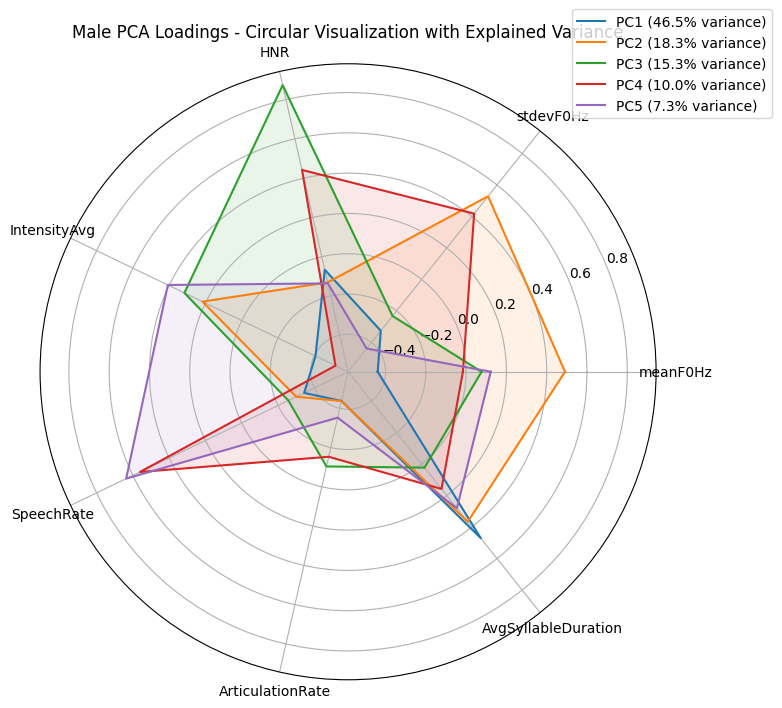


Male PCA Feature Importance and Ranking:
   PCA Component  Explained Variance  Feature Ranking
0              1            0.465322                1
1              2            0.183354                1
2              3            0.152985                1
3              4            0.100044                1
4              5            0.073073                1

Female Data - Original number of features: 7
Female Data - Reduced number of features after PCA: 5

Female PCA Loadings:
                          PC1       PC2       PC3       PC4       PC5
meanF0Hz            -0.415713 -0.383428  0.390846  0.088756 -0.155889
stdevF0Hz           -0.366050 -0.446240  0.418119 -0.173300 -0.036735
HNR                 -0.106316  0.446827  0.515298  0.583104  0.414562
IntensityAvg        -0.303402 -0.195672 -0.488763  0.711281 -0.304188
SpeechRate          -0.367136 -0.208403 -0.392448 -0.120591  0.804148
ArticulationRate    -0.463289  0.442114 -0.097570 -0.273542 -0.191234
AvgSyllableDuration  0

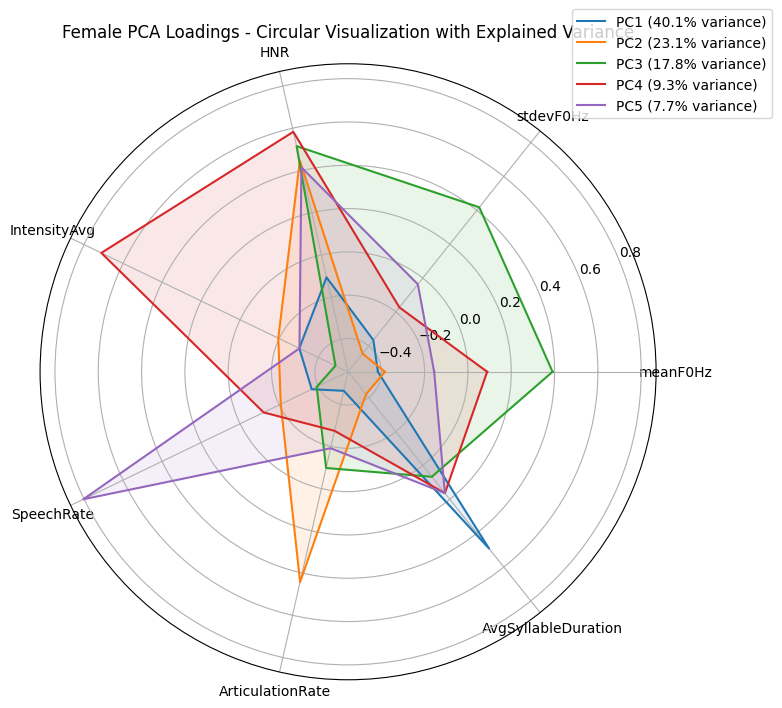


Female PCA Feature Importance and Ranking:
   PCA Component  Explained Variance  Feature Ranking
0              1            0.400585                1
1              2            0.231003                1
2              3            0.178124                1
3              4            0.092604                1
4              5            0.077196                1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# Function to process entries, apply PCA, plot loadings, and perform RFE
def process_entries(entries, gender_label):
    # Preparing the data
    X = entries.drop(['voiceID', 'Semantic_Analysis', 'Acoustic_Annotation', 'Tag'], axis=1)
    y = entries['Tag']

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 1: Standardize the Data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 2: Apply PCA
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"\n{gender_label} Data - Original number of features: {X.shape[1]}")
    print(f"{gender_label} Data - Reduced number of features after PCA: {X_train_pca.shape[1]}")

    # Get PCA loadings
    loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])], index=X.columns)

    # Display loadings for inspection
    print(f"\n{gender_label} PCA Loadings:")
    print(loadings)

    # Plot circular visualization of PCA loadings with explained variance
    explained_variance = pca.explained_variance_ratio_
    explained_variance_percentage = [f"PC{i+1} ({var:.1%} variance)" for i, var in enumerate(explained_variance)]

    # Setup for polar plot
    num_features = len(X.columns)
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each component's loadings
    for i, component_label in enumerate(explained_variance_percentage):
        values = loadings.iloc[:, i].tolist()
        values += values[:1]  # Loop back to the starting point
        ax.plot(angles, values, label=component_label)
        ax.fill(angles, values, alpha=0.1)

    # Add feature labels to the plot
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(X.columns)

    # Add legend with variance explanation
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

    # Display the plot
    plt.title(f"{gender_label} PCA Loadings - Circular Visualization with Explained Variance")
    plt.show()

    # Step 3: Use RFE with Random Forest Classifier
    rf = RandomForestClassifier(random_state=42)
    rfe = RFE(estimator=rf, n_features_to_select=5)  # Select the top 5 features
    rfe.fit(X_train_pca, y_train)

    # Get the selected features
    selected_features = rfe.support_
    feature_ranking = rfe.ranking_

    # Summary of PCA components, variance explained, and feature rankings
    pca_feature_importance = pd.DataFrame({
        'PCA Component': np.arange(1, pca.n_components_ + 1),
        'Explained Variance': pca.explained_variance_ratio_,
        'Feature Ranking': feature_ranking
    })

    print(f"\n{gender_label} PCA Feature Importance and Ranking:")
    print(pca_feature_importance)

# Assuming `df_balanced` contains your dataset
# Filter for female and male entries
female_entries = df_balanced[df_balanced['voiceID'].str.contains(r'F\d{3}')]
male_entries = df_balanced[df_balanced['voiceID'].str.contains(r'M\d{3}')]

# Process both male and female entries
process_entries(male_entries, "Male")
process_entries(female_entries, "Female")
